    !pip install pandas
    !pip install matplotlib
    !pip uninstall numpy -y
    !pip install numpy==1.23.5
    !pip install tensorflow
    !pip install torch
    !pip install torch torchvision
    !pip install scikit-learn
    !pip install seaborn
    !pip install tqdm
    !pip install imblearn

---

1. Configuración Inicial

In [5]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# =============================================
# CONFIGURACIÓN
# =============================================
IMG_SIZE = (224, 224)  # Tamaño estándar para modelos pre-entrenados
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 1e-4
BASE_MODEL = 'EfficientNetB0'  # Puedes probar con otros: ResNet50, VGG16, etc.

# =============================================
# DICCIONARIOS DE MAPEO
# =============================================
label_to_cls_piezas = {
    1: "Antiniebla delantero derecho",
    2: "Antiniebla delantero izquierdo",
    3: "Capó",
    4: "Cerradura capo",
    5: "Cerradura maletero",
    6: "Cerradura puerta",
    7: "Espejo lateral derecho",
    8: "Espejo lateral izquierdo",
    9: "Faros derecho",
    10: "Faros izquierdo",
    11: "Guardabarros delantero derecho",
    12: "Guardabarros delantero izquierdo",
    13: "Guardabarros trasero derecho",
    14: "Guardabarros trasero izquierdo",
    15: "Luz indicadora delantera derecha",
    16: "Luz indicadora delantera izquierda",
    17: "Luz indicadora trasera derecha",
    18: "Luz indicadora trasera izquierda",
    19: "Luz trasera derecho",
    20: "Luz trasera izquierdo",
    21: "Maletero",
    22: "Manija derecha",
    23: "Manija izquierda",
    24: "Marco de la ventana",
    25: "Marco de las puertas",
    26: "Moldura capó",
    27: "Moldura puerta delantera derecha",
    28: "Moldura puerta delantera izquierda",
    29: "Moldura puerta trasera derecha",
    30: "Moldura puerta trasera izquierda",
    31: "Parabrisas delantero",
    32: "Parabrisas trasero",
    33: "Parachoques delantero",
    34: "Parachoques trasero",
    35: "Puerta delantera derecha",
    36: "Puerta delantera izquierda",
    37: "Puerta trasera derecha",
    38: "Puerta trasera izquierda",
    39: "Rejilla, parrilla",
    40: "Rueda",
    41: "Tapa de combustible",
    42: "Tapa de rueda",
    43: "Techo",
    44: "Techo corredizo",
    45: "Ventana delantera derecha",
    46: "Ventana delantera izquierda",
    47: "Ventana trasera derecha",
    48: "Ventana trasera izquierda",
    49: "Ventanilla delantera derecha",
    50: "Ventanilla delantera izquierda",
    51: "Ventanilla trasera derecha",
    52: "Ventanilla trasera izquierda"
}

label_to_cls_danos = {
    1: "Abolladura",
    2: "Deformación",
    3: "Desprendimiento",
    4: "Fractura",
    5: "Rayón",
    6: "Rotura"
}

label_to_cls_sugerencias = {
    1: "Reparar",
    2: "Reemplazar"
}

---
Opcionales

In [ ]:
# Prueba si TensorBoard esta cargado y funcionando
try:
    from torch.utils.tensorboard import SummaryWriter
    print("¡TensorBoard importado correctamente!")
    writer = SummaryWriter()
    writer.add_scalar('test', 1.0, 1)
    writer.close()
    print("Prueba de escritura en TensorBoard completada")
except Exception as e:
    print(f"Error: {str(e)}")

In [ ]:
# Mostrar la version de TensorFlow
print("Versión de TensorFlow:", tf.__version__)
print("Versión de Python:", sys.version)

---

In [2]:
# =============================================
# CARGA DE DATOS
# =============================================
def load_and_prepare_data(split_dir):
    """Carga imágenes y etiquetas para un conjunto (train/val/test)"""
    df = pd.read_csv(f'{split_dir}/{split_dir.split("/")[-1]}_set.csv', sep='|')
    
    # Convertir strings de listas a listas reales
    for col in ['dannos', 'partes', 'sugerencias']:
        df[col] = df[col].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
    
    return df

# Cargar todos los conjuntos
train_df = load_and_prepare_data('data/fotos_siniestros/train')
val_df = load_and_prepare_data('data/fotos_siniestros/val')
test_df = load_and_prepare_data('data/fotos_siniestros/test')

In [3]:
# =============================================
# BALANCEO DE CLASES
# =============================================
def get_class_weights(y):
    # Convertir listas de listas a array 1D para compute_class_weight
    flat_labels = [label for sublist in y for label in sublist]
    classes = np.unique(flat_labels)
    weights = compute_class_weight('balanced', classes=classes, y=flat_labels)
    return dict(zip(classes, weights))

class_weights = {
    'partes': get_class_weights(train_df['partes']),
    'dannos': get_class_weights(train_df['dannos']),
    'sugerencias': get_class_weights(train_df['sugerencias'])
}

In [4]:
# =============================================
# PREPARACIÓN DE ETIQUETAS
# =============================================
# Preparar los binarizadores multi-etiqueta
mlb_partes = MultiLabelBinarizer()
mlb_dannos = MultiLabelBinarizer()
mlb_sugerencias = MultiLabelBinarizer()

# Ajustar y transformar las etiquetas
y_train_partes = mlb_partes.fit_transform(train_df['partes'])
y_train_dannos = mlb_dannos.fit_transform(train_df['dannos'])
y_train_sugerencias = mlb_sugerencias.fit_transform(train_df['sugerencias'])

# Para validación y prueba usamos transform (no fit_transform)
y_val_partes = mlb_partes.transform(val_df['partes'])
y_val_dannos = mlb_dannos.transform(val_df['dannos'])
y_val_sugerencias = mlb_sugerencias.transform(val_df['sugerencias'])

y_test_partes = mlb_partes.transform(test_df['partes'])
y_test_dannos = mlb_dannos.transform(test_df['dannos'])
y_test_sugerencias = mlb_sugerencias.transform(test_df['sugerencias'])

In [5]:
# =============================================
# GENERADOR DE DATOS MEJORADO
# =============================================
class MultiLabelDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, mlb_partes, mlb_dannos, mlb_sugerencias, 
                 batch_size=32, img_size=(224, 224), shuffle=True, augmentation=None):
        self.df = df
        self.img_dir = img_dir
        self.mlb_partes = mlb_partes
        self.mlb_dannos = mlb_dannos
        self.mlb_sugerencias = mlb_sugerencias
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        X = np.empty((len(batch_df), *self.img_size, 3))
        y_partes = []
        y_dannos = []
        y_sugerencias = []
        
        for i, (_, row) in enumerate(batch_df.iterrows()):
            img_path = os.path.join(self.img_dir, row['Imagen'])
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=self.img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            
            if self.augmentation:
                img_array = self.augmentation.random_transform(img_array)
                
            img_array = applications.efficientnet.preprocess_input(img_array)
            X[i] = img_array
            
            y_partes.append(row['partes'])
            y_dannos.append(row['dannos'])
            y_sugerencias.append(row['sugerencias'])
        
        # Asegurar que las etiquetas son arrays numpy 2D
        y_partes = np.array(self.mlb_partes.transform(y_partes), dtype='float32')
        y_dannos = np.array(self.mlb_dannos.transform(y_dannos), dtype='float32')
        y_sugerencias = np.array(self.mlb_sugerencias.transform(y_sugerencias), dtype='float32')
        
        return X, {'partes': y_partes, 'dannos': y_dannos, 'sugerencias': y_sugerencias}
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

# Configuración del aumento de datos
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Directorio de imágenes
IMG_DIR = '../data/fotos_siniestros/'

# Crear generadores
train_generator = MultiLabelDataGenerator(
    train_df, 
    IMG_DIR, 
    mlb_partes, 
    mlb_dannos, 
    mlb_sugerencias,
    batch_size=BATCH_SIZE, 
    img_size=IMG_SIZE,
    augmentation=train_datagen
)

val_generator = MultiLabelDataGenerator(
    val_df, IMG_DIR, mlb_partes, mlb_dannos, mlb_sugerencias, 
    batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False
)

test_generator = MultiLabelDataGenerator(
    test_df, IMG_DIR, mlb_partes, mlb_dannos, mlb_sugerencias, 
    batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False
)

In [6]:
# =============================================
# CONSTRUCCIÓN DEL MODELO
# =============================================
def build_multi_output_model(input_shape, num_partes, num_dannos, num_sugerencias, base_model_name='EfficientNetB0'):
    """Construye un modelo con múltiples salidas"""
    
    # Seleccionar modelo base
    if base_model_name == 'EfficientNetB0':
        base_model = applications.EfficientNetB0(
            include_top=False, 
            weights='imagenet', 
            input_shape=input_shape
        )
    elif base_model_name == 'ResNet50':
        base_model = applications.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=input_shape
        )
    else:
        raise ValueError(f"Modelo base no soportado: {base_model_name}")
    
    # Congelar las capas del modelo base (transfer learning)
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    # Cabezales de salida para cada tarea
    output_partes = layers.Dense(num_partes, activation='sigmoid', name='partes')(x)
    output_dannos = layers.Dense(num_dannos, activation='sigmoid', name='dannos')(x)
    output_sugerencias = layers.Dense(num_sugerencias, activation='sigmoid', name='sugerencias')(x)
    
    model = models.Model(
        inputs=inputs,
        outputs=[output_partes, output_dannos, output_sugerencias]
    )
    
    return model

# Construir modelo
model = build_multi_output_model(
    input_shape=(*IMG_SIZE, 3),
    num_partes=len(mlb_partes.classes_),
    num_dannos=len(mlb_dannos.classes_),
    num_sugerencias=len(mlb_sugerencias.classes_),
    base_model_name=BASE_MODEL
)

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss={
        'partes': 'binary_crossentropy',
        'dannos': 'binary_crossentropy',
        'sugerencias': 'binary_crossentropy'
    },
    metrics={
        'partes': 'accuracy',
        'dannos': 'accuracy',
        'sugerencias': 'accuracy'
    }
)

model.summary()

2025-04-26 15:28:54.482809: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    655,872 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ partes (Dense)      │ (None, 22)        │     11,286 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dannos (Dense)      │ (None, 6)         │      3,078 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sugerencias (Dense) │ (None, 2)         │      1,026 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,720,833 (18.01 MB)

 Trainable params: 671,262 (2.56 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [7]:
# =============================================
# ENTRENAMIENTO
# =============================================
# Callbacks
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Entrenamiento inicial
try:
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        callbacks=[checkpoint, early_stopping],
        class_weight=class_weights,
        verbose=1
    )
except Exception as e:
    print("Error durante el entrenamiento:", str(e))
    # Verifica un batch específico
    test_batch = 0
    X_test, y_test = train_generator[test_batch]
    print(f"\nBatch {test_batch} - Formato X:", X_test.shape)
    for k, v in y_test.items():
        print(f"Formato {k}:", v.shape)

/data/Python/VerificacionDeSiniestrosUsandoMultiplesEtiquetas/.venv-3-11/lib64/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Error durante el entrenamiento: tuple index out of range

Batch 0 - Formato X: (32, 224, 224, 3)
Formato partes: (32, 22)
Formato dannos: (32, 6)
Formato sugerencias: (32, 2)


In [10]:
# =============================================
# SOLUCIÓN DEFINITIVA PARA CARGAR MODELOS
# =============================================

import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def load_model_safely(model_path):
    """Carga un modelo con manejo de errores robusto"""
    try:
        # Primero intentamos cargar como .keras
        if model_path.endswith('.keras'):
            if not os.path.exists(model_path):
                raise FileNotFoundError(f"Archivo {model_path} no encontrado")
            return tf.keras.models.load_model(model_path, compile=False)
        
        # Si es .h5
        elif model_path.endswith('.h5'):
            if not os.path.exists(model_path):
                raise FileNotFoundError(f"Archivo {model_path} no encontrado")
            return tf.keras.models.load_model(model_path, compile=False)
        
        # Si no tiene extensión, probamos ambas
        else:
            keras_path = f"{model_path}.keras"
            h5_path = f"{model_path}.h5"
            
            if os.path.exists(keras_path):
                return tf.keras.models.load_model(keras_path, compile=False)
            elif os.path.exists(h5_path):
                return tf.keras.models.load_model(h5_path, compile=False)
            else:
                raise FileNotFoundError(
                    f"No se encontró {model_path} como .keras o .h5"
                )
                
    except Exception as e:
        print(f"Error al cargar el modelo: {e}")
        raise

# 1. Intenta cargar el modelo de varias formas
model = None
possible_paths = [
    'best_model.keras',
    'best_model.h5',
    'multi_label_car_damage_model_V8.h5',
    'best_fine_tuned_model.h5'
]

for path in possible_paths:
    try:
        model = load_model_safely(path)
        print(f"✅ Modelo cargado exitosamente desde: {path}")
        break
    except Exception as e:
        print(f"⚠️ No se pudo cargar desde {path}: {str(e)}")

# 2. Si no se cargó ningún modelo, reconstruirlo
if model is None:
    print("🔨 Reconstruyendo modelo desde cero...")
    model = build_multi_output_model(
        input_shape=(*IMG_SIZE, 3),
        num_partes=len(mlb_partes.classes_),
        num_dannos=len(mlb_dannos.classes_),
        num_sugerencias=len(mlb_sugerencias.classes_),
        base_model_name=BASE_MODEL
    )
    
    # Compilar el modelo reconstruido
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss={
            'partes': 'binary_crossentropy',
            'dannos': 'binary_crossentropy',
            'sugerencias': 'binary_crossentropy'
        },
        metrics={
            'partes': 'accuracy',
            'dannos': 'accuracy',
            'sugerencias': 'accuracy'
        }
    )

# 3. Configurar fine-tuning
base_model = model.layers[1]
base_model.trainable = True
for layer in base_model.layers[:-5]:  # Descongelar últimas 5 capas
    layer.trainable = False

# 4. Recompilar para fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss={
        'partes': 'binary_crossentropy',
        'dannos': 'binary_crossentropy',
        'sugerencias': 'binary_crossentropy'
    },
    metrics={
        'partes': 'accuracy',
        'dannos': 'accuracy',
        'sugerencias': 'accuracy'
    }
)

# 5. Callbacks simplificados
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'current_best.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
]

# 6. Entrenamiento con manejo de errores
try:
    print("\n🚀 Iniciando fine-tuning...")
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=30,
        initial_epoch=0,
        callbacks=callbacks,
        verbose=1
    )
    
    # Guardar el modelo final
    model.save('final_model.keras')
    print("\n🎉 Entrenamiento completado con éxito!")
    
except Exception as e:
    print(f"\n💥 Error durante el entrenamiento: {str(e)}")
    print("Solución alternativa: Entrenamiento sin callbacks")
    
    try:
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=30,
            verbose=1
        )
        model.save('final_model_no_callbacks.keras')
        print("✅ Modelo guardado sin callbacks")
    except Exception as e:
        print(f"❌ Error crítico: {str(e)}")
        print("Recomendaciones finales:")
        print("1. Verificar la integridad de los datos")
        print("2. Reducir el batch_size a 16 o menos")
        print("3. Reiniciar el entorno de ejecución completamente")

Error al cargar el modelo: Archivo best_model.keras no encontrado
⚠️ No se pudo cargar desde best_model.keras: Archivo best_model.keras no encontrado
✅ Modelo cargado exitosamente desde: best_model.h5

🚀 Iniciando fine-tuning...
Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 31s 976ms/step - dannos_accuracy: 0.6100 - dannos_loss: 0.3762 - loss: 0.9950 - partes_accuracy: 0.3532 - partes_loss: 0.2722 - sugerencias_accuracy: 0.8043 - sugerencias_loss: 0.3786 - val_dannos_accuracy: 0.6842 - val_dannos_loss: 0.3163 - val_loss: 0.7909 - val_partes_accuracy: 0.4386 - val_partes_loss: 0.1763 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3119
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 945ms/step - dannos_accuracy: 0.6138 - dannos_loss: 0.3559 - loss: 0.9435 - partes_accuracy: 0.3470 - partes_loss: 0.2523 - sugerencias_accuracy: 0.8052 - sugerencias_loss: 0.3356 - val_dannos_accuracy: 0.6784 - val_dannos_loss: 0.3148 - val_loss: 0.7912 - val_partes_accuracy: 0.4327 - val_partes_loss: 0.1773

---
Opcional

In [11]:
# Verificar un batch de datos
x, y = next(iter(train_generator))
print("Forma de los datos:", x.shape)
print("Forma de las etiquetas:", {k: v.shape for k, v in y.items()})

Forma de los datos: (32, 224, 224, 3)
Forma de las etiquetas: {'partes': (32, 22), 'dannos': (32, 6), 'sugerencias': (32, 2)}


---

In [12]:
# =============================================
# EVALUACIÓN
# =============================================
def evaluate_model(model, test_generator, mlb_partes, mlb_dannos, mlb_sugerencias):
    """Evalúa el modelo en el conjunto de prueba y muestra métricas"""
    # Evaluación general
    results = model.evaluate(test_generator, verbose=1)
    print(f"Pérdida total: {results[0]}")
    print(f"Pérdida partes: {results[1]} - Accuracy partes: {results[4]}")
    print(f"Pérdida daños: {results[2]} - Accuracy daños: {results[5]}")
    print(f"Pérdida sugerencias: {results[3]} - Accuracy sugerencias: {results[6]}")
    
    # Predicciones
    print("\nGenerando predicciones...")
    predictions = model.predict(test_generator, verbose=1)
    y_pred_partes = predictions[0] > 0.5
    y_pred_dannos = predictions[1] > 0.5
    y_pred_sugerencias = predictions[2] > 0.5
    
    # Obtener etiquetas verdaderas
    y_true_partes = test_generator.mlb_partes.transform(test_df['partes'])
    y_true_dannos = test_generator.mlb_dannos.transform(test_df['dannos'])
    y_true_sugerencias = test_generator.mlb_sugerencias.transform(test_df['sugerencias'])
    
    # Convertir IDs de clases a nombres
    def get_class_names(classes, label_dict):
        return [str(label_dict.get(int(cls), f"Clase_{cls}")) for cls in classes]
    
    partes_names = get_class_names(mlb_partes.classes_, label_to_cls_piezas)
    dannos_names = get_class_names(mlb_dannos.classes_, label_to_cls_danos)
    sugerencias_names = get_class_names(mlb_sugerencias.classes_, label_to_cls_sugerencias)
    
    # Reportes de clasificación
    print("\nReporte para Partes:")
    print(classification_report(
        y_true_partes,
        y_pred_partes,
        target_names=partes_names,
        zero_division=0
    ))
    
    print("\nReporte para Daños:")
    print(classification_report(
        y_true_dannos,
        y_pred_dannos,
        target_names=dannos_names,
        zero_division=0
    ))
    
    print("\nReporte para Sugerencias:")
    print(classification_report(
        y_true_sugerencias,
        y_pred_sugerencias,
        target_names=sugerencias_names,
        zero_division=0
    ))
    
    return {
        'results': results,
        'predictions': {
            'partes': y_pred_partes,
            'dannos': y_pred_dannos,
            'sugerencias': y_pred_sugerencias
        },
        'true_labels': {
            'partes': y_true_partes,
            'dannos': y_true_dannos,
            'sugerencias': y_true_sugerencias
        }
    }

# Realizar evaluación
evaluation_results = evaluate_model(model, test_generator, mlb_partes, mlb_dannos, mlb_sugerencias)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - dannos_accuracy: 0.6041 - dannos_loss: 0.3352 - loss: 0.8033 - partes_accuracy: 0.3778 - partes_loss: 0.1780 - sugerencias_accuracy: 0.8985 - sugerencias_loss: 0.2914
Pérdida total: 0.8417516946792603
Pérdida partes: 0.1888643503189087 - Accuracy partes: 0.589595377445221
Pérdida daños: 0.3660017251968384 - Accuracy daños: 0.3641618490219116
Pérdida sugerencias: 0.2913264334201813 - Accuracy sugerencias: 0.8959537744522095

Generando predicciones...
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 720ms/step

Reporte para Partes:
                                  precision    recall  f1-score   support

                            Capó       0.00      0.00      0.00        12
                   Faros derecho       1.00      0.09      0.17        11
                 Faros izquierdo       0.00      0.00      0.00         9
  Guardabarros delantero derecho       0.00      0.00      0.00        16
Guardabarros delantero izquierdo       0.00      0.00      0.00        17

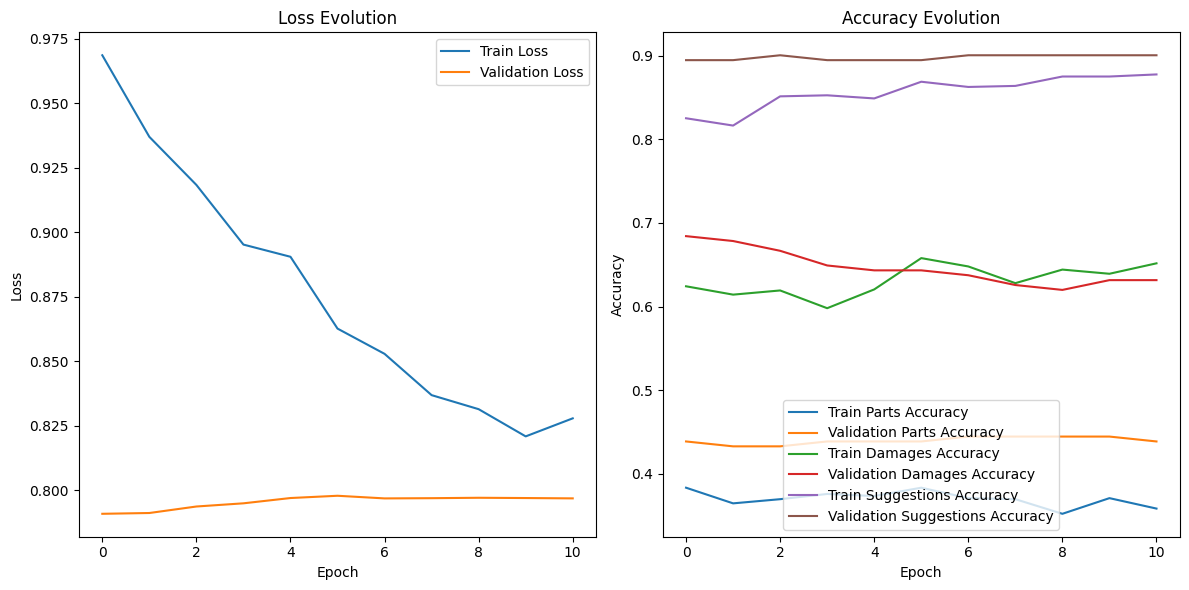

In [13]:
# =============================================
# VISUALIZACIÓN
# =============================================
def plot_training_history(history):
    """Visualiza el historial de entrenamiento"""
    plt.figure(figsize=(12, 6))
    
    # Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['partes_accuracy'], label='Train Parts Accuracy')
    plt.plot(history.history['val_partes_accuracy'], label='Validation Parts Accuracy')
    plt.plot(history.history['dannos_accuracy'], label='Train Damages Accuracy')
    plt.plot(history.history['val_dannos_accuracy'], label='Validation Damages Accuracy')
    plt.plot(history.history['sugerencias_accuracy'], label='Train Suggestions Accuracy')
    plt.plot(history.history['val_sugerencias_accuracy'], label='Validation Suggestions Accuracy')
    plt.title('Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [14]:
# =============================================
# PREDICCIÓN EN NUEVAS IMÁGENES
# =============================================
def predict_damage(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias, img_size=(224, 224)):
    """Realiza predicciones para una nueva imagen"""
    # Cargar y preprocesar la imagen
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Hacer predicción
    predictions = model.predict(img_array)
    
    # Procesar resultados
    partes_probs = predictions[0][0]
    dannos_probs = predictions[1][0]
    sugerencias_probs = predictions[2][0]
    
    # Obtener las clases con mayor probabilidad (top 3 para cada categoría)
    top_partes = sorted(zip(mlb_partes.classes_, partes_probs), key=lambda x: x[1], reverse=True)[:3]
    top_dannos = sorted(zip(mlb_dannos.classes_, dannos_probs), key=lambda x: x[1], reverse=True)[:3]
    top_sugerencias = sorted(zip(mlb_sugerencias.classes_, sugerencias_probs), key=lambda x: x[1], reverse=True)[:3]
    
    # Convertir IDs a nombres
    def get_names(items, label_dict):
        return [(label_dict.get(int(cls), f"Clase_{int(cls)}"), float(prob)) for cls, prob in items]
    
    partes_nombres = get_names(top_partes, label_to_cls_piezas)
    dannos_nombres = get_names(top_dannos, label_to_cls_danos)
    sugerencias_nombres = get_names(top_sugerencias, label_to_cls_sugerencias)
    
    return {
        'partes': partes_nombres,
        'dannos': dannos_nombres,
        'sugerencias': sugerencias_nombres
    }

def print_predictions(prediction):
    print("\nPredicciones para la imagen:")
    for category, items in prediction.items():
        print(f"\n{category.capitalize()}:")
        if not items:
            print("- No se identificaron predicciones significativas")
        else:
            for name, prob in items:
                print(f"- {name}: {prob:.2%} de probabilidad")

In [17]:
# Ejemplo de uso
image_path = "../data/predecir/golpe_01.jpg"  # Asegúrate que esta ruta es correcta
prediction = predict_damage(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias)
print_predictions(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step

Predicciones para la imagen:

Partes:
- Rueda: 18.72% de probabilidad
- Puerta delantera izquierda: 16.03% de probabilidad
- Parachoques trasero: 13.73% de probabilidad

Dannos:
- Abolladura: 73.81% de probabilidad
- Rotura: 51.30% de probabilidad
- Deformación: 10.67% de probabilidad

Sugerencias:
- Reparar: 90.26% de probabilidad
- Reemplazar: 28.25% de probabilidad


In [31]:
# Ruta a la imagen de prueba
# image_path = "../data/predecir/golpe_01.jpg"
# image_path = "../data/predecir/golpe_02.jpg"
# image_path = "../data/predecir/golpe_03.jpg"
# image_path = "../data/predecir/Siniestro_04.jpg"
# image_path = "../data/predecir/Siniestro_03.jpg"
# image_path = "../data/predecir/Siniestro_02.jpg"
# image_path = "../data/predecir/Siniestro_01.jpg"
# image_path = "../data/predecir/rayon_01.jpg"
# image_path = "../data/predecir/rayon_02.jpg"
image_path = "../data/predecir/mica_rota_01.jpg"
# image_path = "../data/predecir/mica_rota-rayon_01.jpg"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


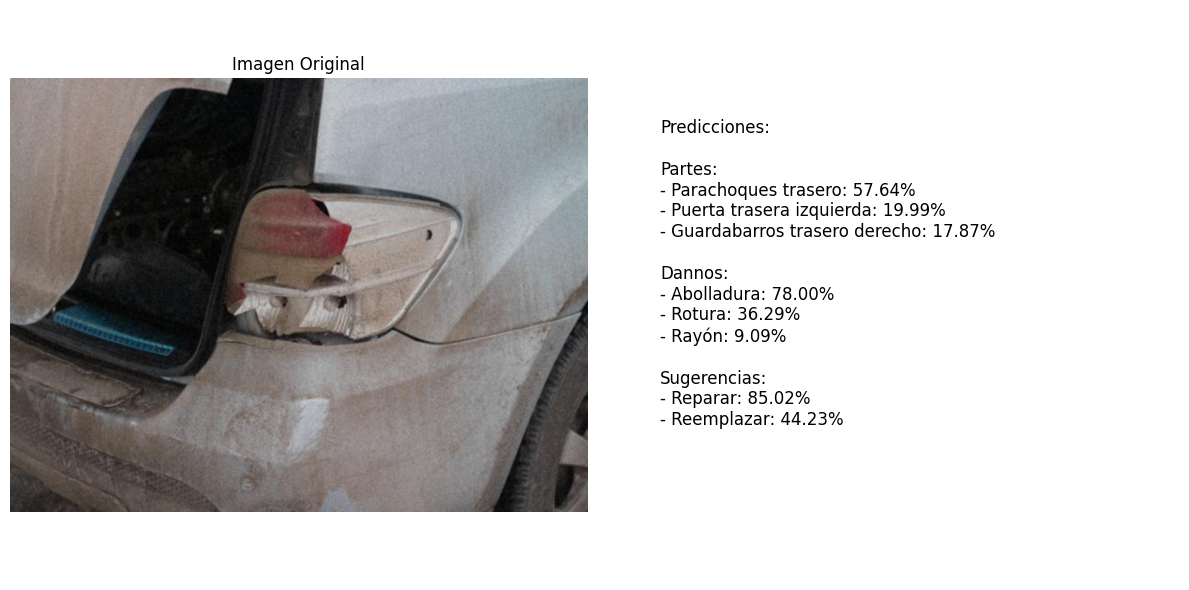


Predicciones para la imagen:

Partes:
- Parachoques trasero: 57.64% de probabilidad
- Puerta trasera izquierda: 19.99% de probabilidad
- Guardabarros trasero derecho: 17.87% de probabilidad

Dannos:
- Abolladura: 78.00% de probabilidad
- Rotura: 36.29% de probabilidad
- Rayón: 9.09% de probabilidad

Sugerencias:
- Reparar: 85.02% de probabilidad
- Reemplazar: 44.23% de probabilidad


In [32]:
# =============================================
# PREDICCIÓN EN NUEVAS IMÁGENES CON VISUALIZACIÓN
# =============================================
import matplotlib.pyplot as plt
import numpy as np

def predict_and_show(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias, img_size=(224, 224)):
    """
    Realiza predicciones para una nueva imagen y la muestra junto con los resultados
    
    Args:
        image_path: Ruta a la imagen a predecir
        model: Modelo cargado para hacer predicciones
        mlb_partes: MultiLabelBinarizer para partes
        mlb_dannos: MultiLabelBinarizer para daños
        mlb_sugerencias: MultiLabelBinarizer para sugerencias
        img_size: Tamaño de la imagen para redimensionamiento
    """
    # Configurar el gráfico
    plt.figure(figsize=(12, 6))
    
    # 1. Mostrar la imagen original
    img = tf.keras.preprocessing.image.load_img(image_path)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Imagen Original")
    plt.axis('off')
    
    # 2. Preprocesar la imagen para el modelo
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.image.resize(img_array, img_size)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    
    # 3. Hacer predicción
    predictions = model.predict(img_array)
    
    # 4. Procesar resultados
    def get_top_predictions(classes, probs, label_dict, top_n=3):
        """Obtiene las top N predicciones con sus nombres y probabilidades"""
        top_items = sorted(zip(classes, probs[0]), key=lambda x: x[1], reverse=True)[:top_n]
        return [(label_dict.get(int(cls), f"Clase_{int(cls)}"), float(prob)) for cls, prob in top_items]
    
    resultados = {
        'partes': get_top_predictions(mlb_partes.classes_, predictions[0], label_to_cls_piezas),
        'dannos': get_top_predictions(mlb_dannos.classes_, predictions[1], label_to_cls_danos),
        'sugerencias': get_top_predictions(mlb_sugerencias.classes_, predictions[2], label_to_cls_sugerencias)
    }
    
    # 5. Mostrar resultados
    plt.subplot(1, 2, 2)
    text_content = "Predicciones:\n\n"
    
    for category, items in resultados.items():
        text_content += f"{category.capitalize()}:\n"
        if not items:
            text_content += "- No se identificaron predicciones significativas\n"
        else:
            for name, prob in items:
                text_content += f"- {name}: {prob:.2%}\n"
        text_content += "\n"
    
    plt.text(0.1, 0.5, text_content, fontsize=12, va='center')
    plt.axis('off')
    plt.tight_layout()
    
    # Mostrar todo
    plt.show()
    
    return resultados

# Ejemplo de uso:
# image_path = "../data/predecir/Siniestro_01.jpg"  # Cambia esto por tu ruta de imagen
resultados = predict_and_show(
    image_path=image_path,
    model=model,
    mlb_partes=mlb_partes,
    mlb_dannos=mlb_dannos,
    mlb_sugerencias=mlb_sugerencias
)

# También puedes usar la función original si prefieres solo texto
def print_predictions(prediction):
    print("\nPredicciones para la imagen:")
    for category, items in prediction.items():
        print(f"\n{category.capitalize()}:")
        if not items:
            print("- No se identificaron predicciones significativas")
        else:
            for name, prob in items:
                print(f"- {name}: {prob:.2%} de probabilidad")

print_predictions(resultados)

In [18]:
# =============================================
# GUARDAR RESULTADOS
# =============================================
def save_evaluation_results(results, filename='evaluation_results.json'):
    """Guarda los resultados de evaluación en un archivo JSON"""
    serializable_results = {
        'metrics': {
            'total_loss': float(results['results'][0]),
            'partes_loss': float(results['results'][1]),
            'dannos_loss': float(results['results'][2]),
            'sugerencias_loss': float(results['results'][3]),
            'partes_accuracy': float(results['results'][4]),
            'dannos_accuracy': float(results['results'][5]),
            'sugerencias_accuracy': float(results['results'][6])
        },
        'predictions': {
            'partes': results['predictions']['partes'].tolist(),
            'dannos': results['predictions']['dannos'].tolist(),
            'sugerencias': results['predictions']['sugerencias'].tolist()
        },
        'true_labels': {
            'partes': results['true_labels']['partes'].tolist(),
            'dannos': results['true_labels']['dannos'].tolist(),
            'sugerencias': results['true_labels']['sugerencias'].tolist()
        }
    }
    
    with open(filename, 'w') as f:
        json.dump(serializable_results, f, indent=2)
    print(f"Resultados guardados en {filename}")

save_evaluation_results(evaluation_results)

Resultados guardados en evaluation_results.json


---

Consideraciones Finales

- Aumento de Datos: Puedes mejorar el modelo añadiendo aumento de datos en el generador de entrenamiento.
- Fine-Tuning: Después del entrenamiento inicial, puedes descongelar algunas capas del modelo base para fine-tuning.
- Balanceo de Clases: Considera usar pesos de clase para manejar el desbalance en las etiquetas.
- Optimización: Experimenta con diferentes modelos base (ResNet, VGG, etc.) y tamaños de imagen.

---